In [3]:
import os,sys
import numpy as np
sys.path.insert(0, '../../fair_classification/') # the code for fair classification is in this directory
import matplotlib.pyplot as plt # for plotting stuff
from scipy.optimize import minimize # for loss func minimization
from collections import defaultdict
from random import seed, shuffle
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

In [4]:
from __future__ import division
import urllib.request
import os,sys
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

sys.path.insert(0, '../../fair_classification/') # the code for fair classification is in this directory
import Utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)

"""
    The adult dataset can be obtained from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
    The code will look for the data file in the present directory, if it is not found, it will download them from GitHub.
"""
from copy import deepcopy

D:\Uni\ThirdTerm\ProjectWork\PythonCode


In [5]:
def load_compas_data():

	FEATURES_CLASSIFICATION = ["age_cat", "priors_count", "c_charge_degree"] #features to be used for classification
	CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
	CLASS_FEATURE = "two_year_recid" # the decision variable
	SENSITIVE_ATTRS = ["sex","race"] 


	COMPAS_INPUT_FILE = "compas-scores-two-years.csv"

	# load the data and get some stats
	df = pd.read_csv(COMPAS_INPUT_FILE)
	df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals
	
	# convert to np array
	data = df.to_dict('list')
	for k in data.keys():
		data[k] = np.array(data[k])


	""" Filtering the data """

	# These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
	# If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense. 
	idx = np.logical_and(data["days_b_screening_arrest"]<=30, data["days_b_screening_arrest"]>=-30)


	# We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
	idx = np.logical_and(idx, data["is_recid"] != -1)

	# In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
	idx = np.logical_and(idx, data["c_charge_degree"] != "O") # F: felony, M: misconduct

	# We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
	idx = np.logical_and(idx, data["score_text"] != "NA")

	# we will only consider blacks and whites for this analysis
	idx = np.logical_and(idx, np.logical_or(data["race"] == "African-American", data["race"] == "Caucasian"))
	# select the examples that satisfy this criteria
	for k in data.keys():
		data[k] = data[k][idx]


	""" Feature normalization and one hot encoding """

	# convert class label 0 to -1
	y = data[CLASS_FEATURE]
	y[y==0] = -1

	
	
	print ("\nNumber of people recidivating within two years")
	print (pd.Series(y).value_counts())
	print ("\n")


	X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
	x_control = defaultdict(list)
	feature_names = []
	for attr in FEATURES_CLASSIFICATION:
		vals = data[attr]
		if attr in CONT_VARIABLES:
			vals = [float(v) for v in vals]
			vals = preprocessing.scale(vals) # 0 mean and 1 variance  
			vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

		else: # for binary categorical variables, the label binarizer uses just one var instead of two
			lb = preprocessing.LabelBinarizer()
			lb.fit(vals)
			vals = lb.transform(vals)

		# add to sensitive features dict
		#if attr in SENSITIVE_ATTRS:
			#x_control[attr] = vals
		#print("x_control",x_control)

		# add to learnable features
		X = np.hstack((X, vals))

		if attr in CONT_VARIABLES: # continuous feature, just append the name
			feature_names.append(attr)
		else: # categorical features
			if vals.shape[1] == 1: # binary features that passed through lib binarizer
				feature_names.append(attr)
			else:
				for k in lb.classes_: # non-binary categorical features, need to add the names for each cat
					feature_names.append(attr + "_" + str(k))
		# add to sensitive features dict
	for attr in SENSITIVE_ATTRS:
		x_control[attr] = data[attr]
	#print("x_control0",x_control)                    
	# convert the sensitive feature to 1-d array
	x_control = dict(x_control)
	#print ("x_control",x_control)
	binary_encoded_data = {}   
	# Iterate through the keys (sensitive attributes) in the x_control dictionary
	for attr in x_control:
		# Perform binary encoding for each attribute separately

		# For 'race' attribute:
		if attr == 'race':
			# Convert the value of the 'race' attribute to a NumPy array if it is not already
			race_array = np.array(x_control[attr])
			race_binary = (race_array == 'Caucasian').astype(int)
			binary_encoded_data[attr] = race_binary

		# For 'sex' attribute:
		elif attr == 'sex':
			# Convert the value of the 'sex' attribute to a NumPy array if it is not already
			sex_array = np.array(x_control[attr])
			sex_binary = (sex_array == 'Female').astype(int)
			binary_encoded_data[attr] = sex_binary
	x_control = binary_encoded_data

	"""permute the date randomly"""
	perm = list(range(0,X.shape[0]))
	shuffle(perm)
	X = X[perm]
	y = y[perm]
	for k in x_control.keys():
		x_control[k] = x_control[k][perm]


	X = ut.add_intercept(X)  

	feature_names = ["intercept"] + feature_names
	assert(len(feature_names) == X.shape[1])
	print ("Features we will be using for classification are:", feature_names, "\n")


	return X, y, x_control

In [6]:
def split_into_train_test(x_all, y_all, x_control_all, train_fold_size):

    split_point = int(round(float(x_all.shape[0]) * train_fold_size))
    x_all_train = x_all[:split_point]
    x_all_test = x_all[split_point:]
    y_all_train = y_all[:split_point]
    y_all_test = y_all[split_point:]
    x_control_all_train = {}
    x_control_all_test = {}
    for k in x_control_all.keys():
        x_control_all_train[k] = x_control_all[k][:split_point]
        x_control_all_test[k] = x_control_all[k][split_point:]

    return x_all_train, y_all_train, x_control_all_train, x_all_test, y_all_test, x_control_all_test

In [7]:
def _logistic_loss(w, X, y, return_arr=None):
	"""Computes the logistic loss.

	This function is used from scikit-learn source code

	Parameters
	----------
	w : ndarray, shape (n_features,) or (n_features + 1,)
	    Coefficient vector.

	X : {array-like, sparse matrix}, shape (n_samples, n_features)
	    Training data.

	y : ndarray, shape (n_samples,)
	    Array of labels.

	"""
	

	yz = y * np.dot(X,w)
	# Logistic loss is the negative of the log of the logistic function.
	if return_arr == True:
		out = -(log_logistic(yz))
	else:
		out = -np.sum(log_logistic(yz))
	return out

def log_logistic(X):

	""" This function is used from scikit-learn source code. Source link below """

	"""Compute the log of the logistic function, ``log(1 / (1 + e ** -x))``.
	This implementation is numerically stable because it splits positive and
	negative values::
	    -log(1 + exp(-x_i))     if x_i > 0
	    x_i - log(1 + exp(x_i)) if x_i <= 0

	Parameters
	----------
	X: array-like, shape (M, N)
	    Argument to the logistic function

	Returns
	-------
	out: array, shape (M, N)
	    Log of the logistic function evaluated at every point in x
	Notes
	-----
	Source code at:
	https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/extmath.py
	-----

	See the blog post describing this implementation:
	http://fa.bianp.net/blog/2013/numerical-optimizers-for-logistic-regression/
	"""
	if X.ndim > 1: raise Exception("Array of samples cannot be more than 1-D!")
	out = np.empty_like(X) # same dimensions and data types

	idx = X>0
	out[idx] = -np.log(1.0 + np.exp(-X[idx]))
	out[~idx] = X[~idx] - np.log(1.0 + np.exp(X[~idx]))
	return out

In [8]:
def compute_p_rule(x_control, class_labels):
    """Compute the p-rule based on Doctrine of disparate impact"""
    
    non_prot_all = sum(x_control == 1.0)  # non-protected group
    prot_all = sum(x_control == 0.0)  # protected group
    non_prot_pos = sum(class_labels[x_control == 1.0] == 1.0)  # non_protected in positive class
    prot_pos = sum(class_labels[x_control == 0.0] == 1.0)  # protected in positive class
    frac_non_prot_pos = float(non_prot_pos) / float(non_prot_all)
    frac_prot_pos = float(prot_pos) / float(prot_all)
    p_rule = (min( (frac_non_prot_pos / frac_prot_pos), (frac_prot_pos / frac_non_prot_pos) )) * 100.0
    print()
    print("Total data points: %d" % len(x_control))
    print("# non-protected examples: %d" % non_prot_all)
    print("# protected examples: %d" % prot_all)
    print(
        "Non-protected in positive class: %d (%0.0f%%)"
        % (non_prot_pos, non_prot_pos * 100.0 / non_prot_all)
    )
    print(
        "Protected in positive class: %d (%0.0f%%)"
        % (prot_pos, prot_pos * 100.0 / prot_all)
    )
    print("P-rule is: %0.0f%%" % p_rule)
    return p_rule

In [9]:
def print_covariance_sensitive_attrs(model, x_arr, y_arr_dist_boundary, x_control, sensitive_attrs):

    """
    reutrns the covariance between sensitive features and distance from decision boundary
    """
    arr = []
    arr = y_arr_dist_boundary # simplt the output labels
    
    sensitive_attrs_to_cov_original = {}
    for attr in sensitive_attrs:

        attr_arr = x_control[attr]

        thresh = 0
        cov = thresh - test_sensitive_attr_constraint_cov(None, x_arr, arr, np.array(attr_arr), thresh, False)
        sensitive_attrs_to_cov_original[attr] = cov
       
            
    return sensitive_attrs_to_cov_original


In [10]:
def get_constraint_list_cov(x_train, y_train, x_control_train, sensitive_attrs, sensitive_attrs_to_cov_thresh):

    """
    get the list of constraints to be fed to the minimizer
    """

    constraints = []
    for attr in sensitive_attrs:
        attr_arr = x_control_train["sex"]
        integer_elements = []
        for k in attr_arr:
            try:
                k = int(k)
            except (ValueError, TypeError):
                print(f"Error: Element '{k}' cannot be converted to an integer.")
                return np.array([])
            integer_elements.append(k)
        attr_arr_transformed= np.array(integer_elements)
        thresh = sensitive_attrs_to_cov_thresh[attr]
        c = ({'type': 'ineq', 'fun': test_sensitive_attr_constraint_cov, 'args':(x_train, y_train, attr_arr_transformed,thresh, False)})
        constraints.append(c)
    return constraints


In [11]:
def test_sensitive_attr_constraint_cov(model, x_arr, y_arr_dist_boundary, x_control, thresh, verbose):

    """
    The covariance is computed b/w the sensitive attr val and the distance from the boundary
    If the model is None, we assume that the y_arr_dist_boundary contains the distace from the decision boundary
    If the model is not None, we just compute a dot product or model and x_arr
    this function will return -1 if the constraint specified by thresh parameter is not satifsified
    otherwise it will reutrn +1
    if the return value is >=0, then the constraint is satisfied
    """

    assert(x_arr.shape[0] == x_control.shape[0])
    if len(x_control.shape) > 1: # make sure we just have one column in the array
        assert(x_control.shape[1] == 1)
    
    arr = []
    if model is None:
        arr = y_arr_dist_boundary # simply the output labels
    else:
        arr = np.dot(model, x_arr.T) # the product with the weight vector -- the sign of this is the output label
    
    arr = np.array(arr, dtype=np.float64)
    cov = np.dot(x_control - np.mean(x_control), arr ) / float(len(x_control))
   
    ans = thresh - abs(cov) # will be <0 if the covariance is greater than thresh -- that is, the condition is not satisfied
    if verbose is True:
        print ("Covariance is", cov)
        print ("Diff is:", ans)
        print ()
    return ans

In [12]:
def check_accuracy(model, x_train, y_train, x_test, y_test, y_train_predicted, y_test_predicted):


    """
    returns the train/test accuracy of the model
    """

    y_test_predicted = np.sign(np.dot(x_test, model))
    y_train_predicted = np.sign(np.dot(x_train, model))

    def get_accuracy(y, Y_predicted):
        correct_answers = (Y_predicted == y).astype(int) # will have 1 when the prediction and the actual label match
        accuracy = float(sum(correct_answers)) / float(len(correct_answers))
        return accuracy, sum(correct_answers)

    train_score, correct_answers_train = get_accuracy(y_train, y_train_predicted)
    test_score, correct_answers_test = get_accuracy(y_test, y_test_predicted)

    return train_score, test_score, correct_answers_train, correct_answers_test

In [13]:
def get_correlations(model, x_test, y_predicted, x_control_test, sensitive_attrs):
    

    """
    returns the fraction in positive class for sensitive feature values
    """
 
    y_predicted = np.array(y_predicted)
    
    out_dict = {}
    for attr in sensitive_attrs:

        attr_val = []
        for v in x_control_test[attr]: attr_val.append(v)
        assert(len(attr_val) == len(y_predicted))


        total_per_val = defaultdict(int)
        attr_to_class_labels_dict = defaultdict(lambda: defaultdict(int))

        for i in range(0, len(y_predicted)):
            val = attr_val[i]
            label = y_predicted[i]

            # val = attr_val_int_mapping_dict_reversed[val] # change values from intgers to actual names
            total_per_val[val] += 1
            attr_to_class_labels_dict[val][label] += 1

        class_labels = set(y_predicted.tolist())

        local_dict_1 = {}
        for k1,v1 in attr_to_class_labels_dict.items():
            total_this_val = total_per_val[k1]

            local_dict_2 = {}
            for k2 in class_labels: # the order should be the same for printing
                v2 = v1[k2]

                f = float(v2) * 100.0 / float(total_this_val)


                local_dict_2[k2] = f
            local_dict_1[k1] = local_dict_2
        out_dict[attr] = local_dict_1

    return out_dict

In [14]:
def get_avg_correlation_dict(correlation_dict_arr):
    # make the structure for the correlation dict
    correlation_dict_avg = {}
    # print correlation_dict_arr
    for k,v in correlation_dict_arr[0].items():
        correlation_dict_avg[k] = {}
        for feature_val, feature_dict in v.items():
            correlation_dict_avg[k][feature_val] = {}
            for class_label, frac_class in feature_dict.items():
                correlation_dict_avg[k][feature_val][class_label] = []

    # populate the correlation dict
    for correlation_dict in correlation_dict_arr:
        for k,v in correlation_dict.items():
            for feature_val, feature_dict in v.items():
                for class_label, frac_class in feature_dict.items():
                    correlation_dict_avg[k][feature_val][class_label].append(frac_class)

    # now take the averages
    for k,v in correlation_dict_avg.items():
        for feature_val, feature_dict in v.items():
            for class_label, frac_class_arr in feature_dict.items():
                correlation_dict_avg[k][feature_val][class_label] = np.mean(frac_class_arr)

    return correlation_dict_avg


In [15]:
def add_intercept(x):

    """ Add intercept to the data before linear classification """
    m,n = x.shape
    intercept = np.ones(m).reshape(m, 1) # the constant b
    return np.concatenate((intercept, x), axis = 1)

In [16]:
def print_classifier_fairness_stats(acc_arr, correlation_dict_arr, cov_dict_arr, s_attr_name):
    
    correlation_dict = get_avg_correlation_dict(correlation_dict_arr)
    non_prot_pos = correlation_dict[s_attr_name][1][1]
    prot_pos = correlation_dict[s_attr_name][0][1]
    p_rule = (min( (non_prot_pos / prot_pos), (prot_pos / non_prot_pos) )) * 100.0
    print ("Accuracy: %0.2f" % (np.mean(acc_arr)) )
    print ("Protected/non-protected in +ve class: %0.0f%% / %0.0f%%" % (prot_pos, non_prot_pos) )
    print ("P-rule achieved: %0.0f%%" % (p_rule) )
    print ("Covariance between sensitive feature and decision from distance boundary : %0.3f" % (np.mean([v[s_attr_name] for v in cov_dict_arr])))
    print ()
    return p_rule

In [17]:
def compute_cross_validation_error(x_all, y_all, x_control_all, num_folds, loss_function, apply_fairness_constraints, sensitive_attrs, sensitive_attrs_to_cov_thresh_arr):
    n_samples = len(y_all)
    train_fold_size = 0.7  # the rest of 0.3 is for testing
    max_iter = 10000 # maximum number of iterations for the minimization algorithm
    train_folds = []
    test_folds = []

    # Split the data into folds for cross-validation
    for i in range(num_folds):
        perm = list(range(n_samples))
        shuffle(perm)
        x_all_perm = x_all[perm]
        y_all_perm = y_all[perm]
        x_control_all_perm = {k: np.array(x_control_all[k])[perm] for k in x_control_all.keys()}

        x_all_train, y_all_train, x_control_all_train, x_all_test, y_all_test, x_control_all_test = split_into_train_test(x_all_perm, y_all_perm, x_control_all_perm, train_fold_size)

        train_folds.append([x_all_train, y_all_train, x_control_all_train])
        test_folds.append([x_all_test, y_all_test, x_control_all_test])

    test_acc_arr = []
    train_acc_arr = []
    correlation_dict_test_arr = []
    correlation_dict_train_arr = []
    cov_dict_test_arr = []
    cov_dict_train_arr = []
    for fold_num in range(num_folds):
        train_data = train_folds[fold_num]
        test_data = test_folds[fold_num]
        sensitive_attrs_to_cov_thresh = sensitive_attrs_to_cov_thresh_arr[fold_num]
        #print ('sensitive_attrs_to_cov_thresh',sensitive_attrs_to_cov_thresh)
        x_train, y_train, x_control_train = train_data
        x_test, y_test, x_control_test = test_data
        f_args=(x_train, y_train)
        if apply_fairness_constraints == 0:
            w = minimize(fun = loss_function,
                 x0 = np.random.rand(x_train.shape[1],),       
                 args = f_args, 
                 method = 'SLSQP',
                 options = {"maxiter":max_iter},
                 constraints = []
                 )
        else: 
            constraints = get_constraint_list_cov(x_train, y_train,x_control_train, sensitive_attrs, sensitive_attrs_to_cov_thresh)  
            w = minimize(fun = loss_function,
                 x0 = np.random.rand(x_train.shape[1],),       
                 args = f_args, 
                 method = 'SLSQP',
                 options = {"maxiter":max_iter},
                 constraints = constraints
                 )     
        try:
            assert(w.success == True)
        except:
            print ("Optimization problem did not converge.. Check the solution returned by the optimizer.")
            print ("Returned solution is:")
            print (w)             
        train_score, test_score, correct_answers_train, correct_answers_test = check_accuracy(w.x, x_train, y_train, x_test, y_test, None, None)
        distances_boundary_test = (np.dot(x_test, w.x)).tolist()
        all_class_labels_assigned_test = np.sign(distances_boundary_test)
        correlation_dict_test = get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
        cov_dict_test = print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)

        distances_boundary_train = (np.dot(x_train, w.x)).tolist()
        all_class_labels_assigned_train = np.sign(distances_boundary_train)
        correlation_dict_train = get_correlations(None, None, all_class_labels_assigned_train, x_control_train, sensitive_attrs)
        cov_dict_train = print_covariance_sensitive_attrs(None, x_train, distances_boundary_train, x_control_train, sensitive_attrs)

        test_acc_arr.append(test_score)
        train_acc_arr.append(train_score)
        correlation_dict_test_arr.append(correlation_dict_test)
        correlation_dict_train_arr.append(correlation_dict_train)
        cov_dict_test_arr.append(cov_dict_test)
        cov_dict_train_arr.append(cov_dict_train)
                 

    return test_acc_arr, train_acc_arr, correlation_dict_test_arr, correlation_dict_train_arr, cov_dict_test_arr, cov_dict_train_arr


In [18]:
def plot_cov_thresh_vs_acc_pos_ratio(x_all, y_all, x_control_all, num_folds, loss_function, sensitive_attrs):


    # very the covariance threshold using a range of decreasing multiplicative factors and see the tradeoffs between accuracy and fairness
    it = 0.05
    cov_range = np.arange(1.0, 0.0-it, -it).tolist()
    
    positive_class_label = 1 # positive class is +1
    train_acc = []
    test_acc = []
    positive_per_category = defaultdict(list) # for each category (male / female), the frac of positive

    # first get the original values of covariance in the unconstrained classifier -- these original values are not needed for reverse constraint    
    test_acc_arr, train_acc_arr, correlation_dict_test_arr, correlation_dict_train_arr, cov_dict_test_arr, cov_dict_train_arr = compute_cross_validation_error(x_all, y_all, x_control_all, num_folds, loss_function, 0, sensitive_attrs, [{} for i in range(0,num_folds)])

    for c in cov_range:
        print ("LOG: testing for multiplicative factor: %0.2f" % c)
        sensitive_attrs_to_cov_original_arr_multiplied = []
        for sensitive_attrs_to_cov_original in cov_dict_train_arr:
            sensitive_attrs_to_cov_thresh = deepcopy(sensitive_attrs_to_cov_original)
            for k in sensitive_attrs_to_cov_thresh.keys():
                v = sensitive_attrs_to_cov_thresh[k]
                if type(v) == type({}):
                    for k1 in v.keys():
                        v[k1] = v[k1] * c
                else:
                    sensitive_attrs_to_cov_thresh[k] = v * c
            sensitive_attrs_to_cov_original_arr_multiplied.append(sensitive_attrs_to_cov_thresh)


        test_acc_arr, train_acc_arr, correlation_dict_test_arr, correlation_dict_train_arr, cov_dict_test_arr, cov_dict_train_arr  = compute_cross_validation_error(x_all, y_all, x_control_all, num_folds, loss_function, 1, sensitive_attrs, sensitive_attrs_to_cov_original_arr_multiplied)
        test_acc.append(np.mean(test_acc_arr))


        correlation_dict_train = get_avg_correlation_dict(correlation_dict_train_arr)
        correlation_dict_test = get_avg_correlation_dict(correlation_dict_test_arr)
        
        # just plot the correlations for the first sensitive attr, the plotting can be extended for the other values, but as a proof of concept, we will jsut show for one
        s = sensitive_attrs[0]    
        
        for k,v in correlation_dict_test[s].items():
            if v.get(positive_class_label) is None:
                positive_per_category[k].append(0.0)
            else:
                positive_per_category[k].append(v[positive_class_label])
    
    positive_per_category = dict(positive_per_category)
    
    ratios = np.array(positive_per_category[1]) / np.array(positive_per_category[0])
    reverse_ratios = np.array(positive_per_category[0]) / np.array(positive_per_category[1])
    # Calculate the minimum ratio between ratios and reverse_ratios element-wise
    p_rule_arr = np.minimum(ratios, reverse_ratios) * 100.0
    

    ax = plt.subplot(2,1,1)
    plt.plot(cov_range, positive_per_category[0], "-o" , color="green", label = "Protected")
    plt.plot(cov_range, positive_per_category[1], "-o", color="blue", label = "Non-protected")
    ax.set_xlim([min(cov_range), max(cov_range)])
    plt.ylabel('Perc. in positive class')
    plt.gca().invert_xaxis()
    plt.xlabel('Multiplicative covariance factor (c)')
    ax.legend()

    ax = plt.subplot(2,1,2)
    plt.scatter(p_rule_arr, test_acc, color="red")
    ax.set_xlim([min(p_rule_arr), max(max(p_rule_arr), 100)])
    plt.xlabel('P% rule')
    plt.ylabel('Accuracy')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    plt.show()



Number of people recidivating within two years
-1    2795
 1    2483
Name: count, dtype: int64


Features we will be using for classification are: ['intercept', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'priors_count', 'c_charge_degree'] 


Total data points: 5278
# non-protected examples: 1031
# protected examples: 4247
Non-protected in positive class: 373 (36%)
Protected in positive class: 2110 (50%)
P-rule is: 73%

== (Original) classifier ==
Accuracy: 0.66
Protected/non-protected in +ve class: 46% / 32%
P-rule achieved: 70%
Covariance between sensitive feature and decision from distance boundary : 0.041


== Constrained (fair) classifier ==
Accuracy: 0.55
Protected/non-protected in +ve class: 44% / 42%
P-rule achieved: 96%
Covariance between sensitive feature and decision from distance boundary : 0.003

LOG: testing for multiplicative factor: 1.00
LOG: testing for multiplicative factor: 0.95
LOG: testing for multiplicative factor: 0.90
LOG: testing for 

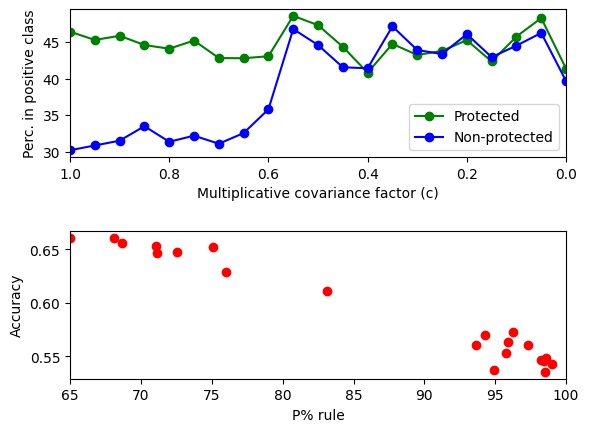

In [19]:
NUM_FOLDS = 10 # we will show 10-fold cross validation accuracy as a performance measure

def test_data():

    """ Load the adult data """
    X, y, x_control = load_compas_data() # set the argument to none, or no arguments if you want to test with the whole data -- we are subsampling for performance speedup
    compute_p_rule(x_control["sex"], y) # compute the p-rule in the original data

    loss_function = _logistic_loss
    X = add_intercept(X) # add intercept to X before applying the linear classifier
    print()
    print ("== (Original) classifier ==")
    cov_factor = 0
    test_acc_arr, train_acc_arr, correlation_dict_test_arr, correlation_dict_train_arr, cov_dict_test_arr, cov_dict_train_arr = compute_cross_validation_error(X, y, x_control, NUM_FOLDS, loss_function, 0, ['sex'], [{'sex':cov_factor} for i in range(0,NUM_FOLDS)])		
    print_classifier_fairness_stats(test_acc_arr, correlation_dict_test_arr, cov_dict_test_arr, 'sex')
    print()
    print ("== Constrained (fair) classifier ==")
    cov_factor = 0
    test_acc_arr, train_acc_arr, correlation_dict_test_arr, correlation_dict_train_arr, cov_dict_test_arr, cov_dict_train_arr = compute_cross_validation_error(X, y, x_control, NUM_FOLDS, loss_function, 1, ['sex'], [{'sex':cov_factor} for i in range(0,NUM_FOLDS)])		
    
    print_classifier_fairness_stats(test_acc_arr, correlation_dict_test_arr, cov_dict_test_arr, 'sex')
    
    """ Now plot a tradeoff between the fairness and accuracy """
    plot_cov_thresh_vs_acc_pos_ratio(X, y, x_control, NUM_FOLDS, loss_function, ['sex'])
    


def main():
    test_data()


if __name__ == '__main__':
    main()